# Pokémon Generations Analysis

[Pokémon](https://en.wikipedia.org/wiki/Pok%C3%A9mon) is a multimedia japanese franchise firtly developed as a video game for the original game boy in 1996. The following report uses data made availiable by [Keith Galli](https://github.com/KeithGalli) that contains information about all the pokémons from the 6 first generations. This report aims to answer the following questions:

* What is the most common and rare type of pokémon?
* What is the strongest and weakest pokémon?
* What is the strongest and weakest pokémon generation?
* Can pokémons be grouped according to their strengths?



## Setting up the data

We start our analysis by loading and getting some general information about the data.


In [55]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

df = pd.read_csv("https://raw.githubusercontent.com/KeithGalli/pandas/master/pokemon_data.csv")

df.describe(include='all')

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,800.000000,800,800,414,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800
unique,NaN,800,18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Zebstrika,Water,Flying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,1,112,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735
mean,362.813750,NaN,NaN,NaN,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,NaN
std,208.343798,NaN,NaN,NaN,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,NaN
min,1.000000,NaN,NaN,NaN,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,NaN
25%,184.750000,NaN,NaN,NaN,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,NaN
50%,364.500000,NaN,NaN,NaN,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,NaN
75%,539.250000,NaN,NaN,NaN,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,NaN


We have 12 columns with auto descriptive names and 800 rows. The **Name**, **Type 1** and **Type 2** columns contain text values. The **Legendary** column contains boolean values. The rest of the columns are numerical. Let us check the first rows of the dataframe.

In [56]:
df.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


The **#** columns represents the pokedex number of the pokémon. We have some *Mega* pokémons, which are just a stronger version of specific pokémons. We will be removing them from the data.

In [57]:
df = df[~df['Name'].str.contains("Mega")].reset_index(drop=True)
df.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False


Let us check the columns types.

In [58]:
df.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

The **Generation** column will be better treated as a categorical variable. We will be also removing the **#** column.

In [59]:
df['Generation'] = df['Generation'].astype('category')
df = df.drop(columns=['#'])
df.dtypes

Name            object
Type 1          object
Type 2          object
HP               int64
Attack           int64
Defense          int64
Sp. Atk          int64
Sp. Def          int64
Speed            int64
Generation    category
Legendary         bool
dtype: object

Now that we removed the *Mega* pokémon from the data, let us see how many pokémons we have got left and save the tidy data in a csv file.

In [60]:
print("Number of pokémons:", df['Name'].nunique())
df.to_csv("pokemon.csv", index=False)

Number of pokémons: 751


## Pokémon Types

Each pokémon has mandatorily one and a maximum of two types. Let us see how many different types we have accross all generations.

In [61]:
ntypes = pd.concat([df['Type 1'], df['Type 2']]).nunique()
print("Number of distinct pokémon types:", ntypes)
types = pd.concat([df['Type 1'], df['Type 2']]).unique()
print("Pokémon types:",types)

Number of distinct pokémon types: 18
Pokémon types: ['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying' nan]


We have 18 different types of pokémons. The *nan* value appears because not all pokémons have two types. Let us see the proportion of pokémons with two types.

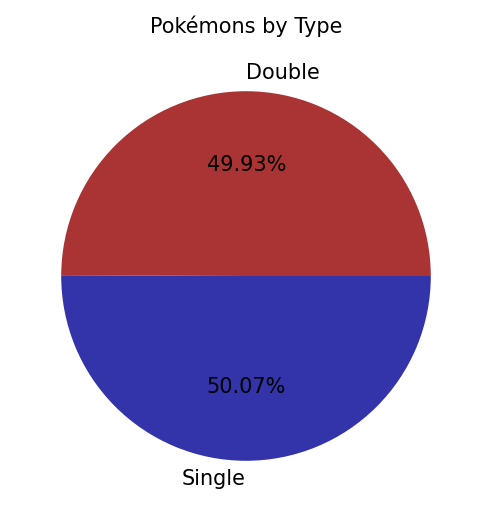

In [62]:
df['ntype'] = np.where(df['Type 2'].isna(), 'Single', 'Double')
df_by_ntype = df.groupby('ntype')['Name'].count()

fig, ax = plt.subplots(figsize=(4,4), dpi=150)
ax.pie(df_by_ntype, labels=df_by_ntype.index, autopct="%.2f%%", colors=['#AA3333', '#3333AA'])
ax.set_title("Pokémons by Type", fontdict={'fontsize':10})
plt.show()

The amount of single and double type pokémon is very balanced. Let us see if this behavior is homogeneous for all generations

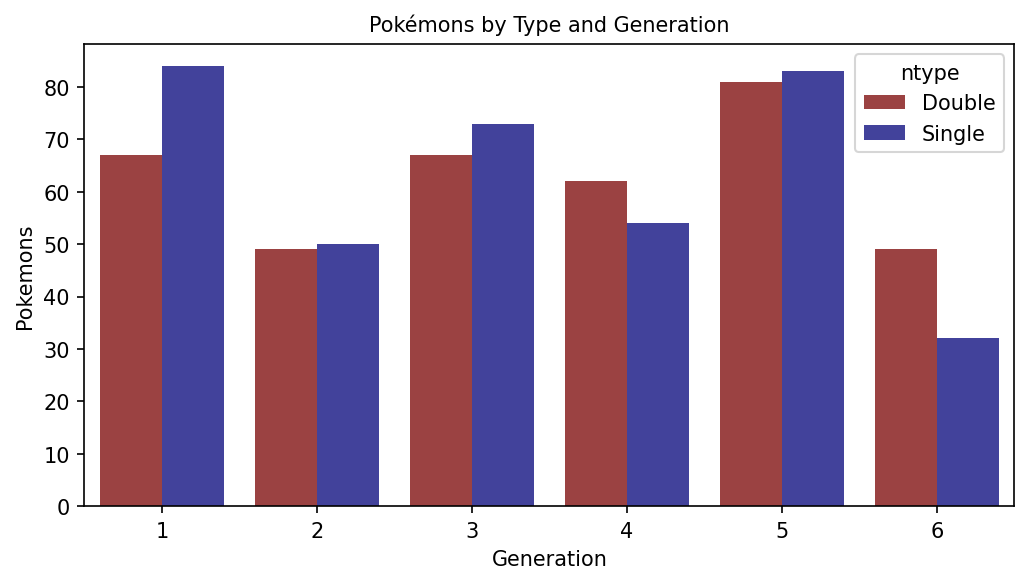

In [63]:
df_by_generation_ntype = df.groupby(['Generation', 'ntype']).agg(Pokemons=('Name', pd.Series.count)).reset_index()
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ntype_palette = {'Single':'#3333AA', 'Double':'#AA3333'}
sns.barplot(x='Generation', y='Pokemons', hue='ntype', data=df_by_generation_ntype, palette=ntype_palette, ax=ax)
ax.set_title("Pokémons by Type and Generation", fontdict={'fontsize':10})
plt.show()

The amount of single and double type pokémons is pretty much balanced across all generations, with the first and sixth having the largest differences. The amount of double type pokémon is larger only in the fourth and sixth generations. Let us see how many pokémons we have for each type.

In [64]:
df_pokemon_by_type1 = df.groupby(['Type 1']).agg(Pokemons=('Name', pd.Series.nunique)).reset_index()
df_pokemon_by_type2 = df.groupby(['Type 2']).agg(Pokemons=('Name', pd.Series.nunique)).reset_index()
df_pokemon_by_type = df_pokemon_by_type1.merge(df_pokemon_by_type2, how='outer', left_on='Type 1', right_on='Type 2',
                                               suffixes=('_1', '_2'))
df_pokemon_by_type['Pokemons'] = df_pokemon_by_type['Pokemons_1']+df_pokemon_by_type['Pokemons_2']
df_pokemon_by_type = df_pokemon_by_type[['Type 1', 'Pokemons']].rename(columns={'Type 1':'Type'})\
                                                               .sort_values(['Pokemons'], ascending=False)\
                                                               .reset_index(drop=True)
df_pokemon_by_type

,Type,Pokemons
0,Water,121
1,Normal,98
2,Flying,95
3,Grass,91
4,Psychic,80
5,Bug,68
6,Ground,63
7,Fire,59
8,Poison,59
9,Rock,55


Water type pokémons are the most common ones and the fairy type ones are the rarest. This can maybe explained by the fact that fairy pokémons were introduced in the latter generations.

## Pokémon Strength Comparison

Every pokémon has 6 attributes that can be used to compare them: HP, attack, defense, super attack, super defense and speed. Let us see how each of these attributes relates with each other.

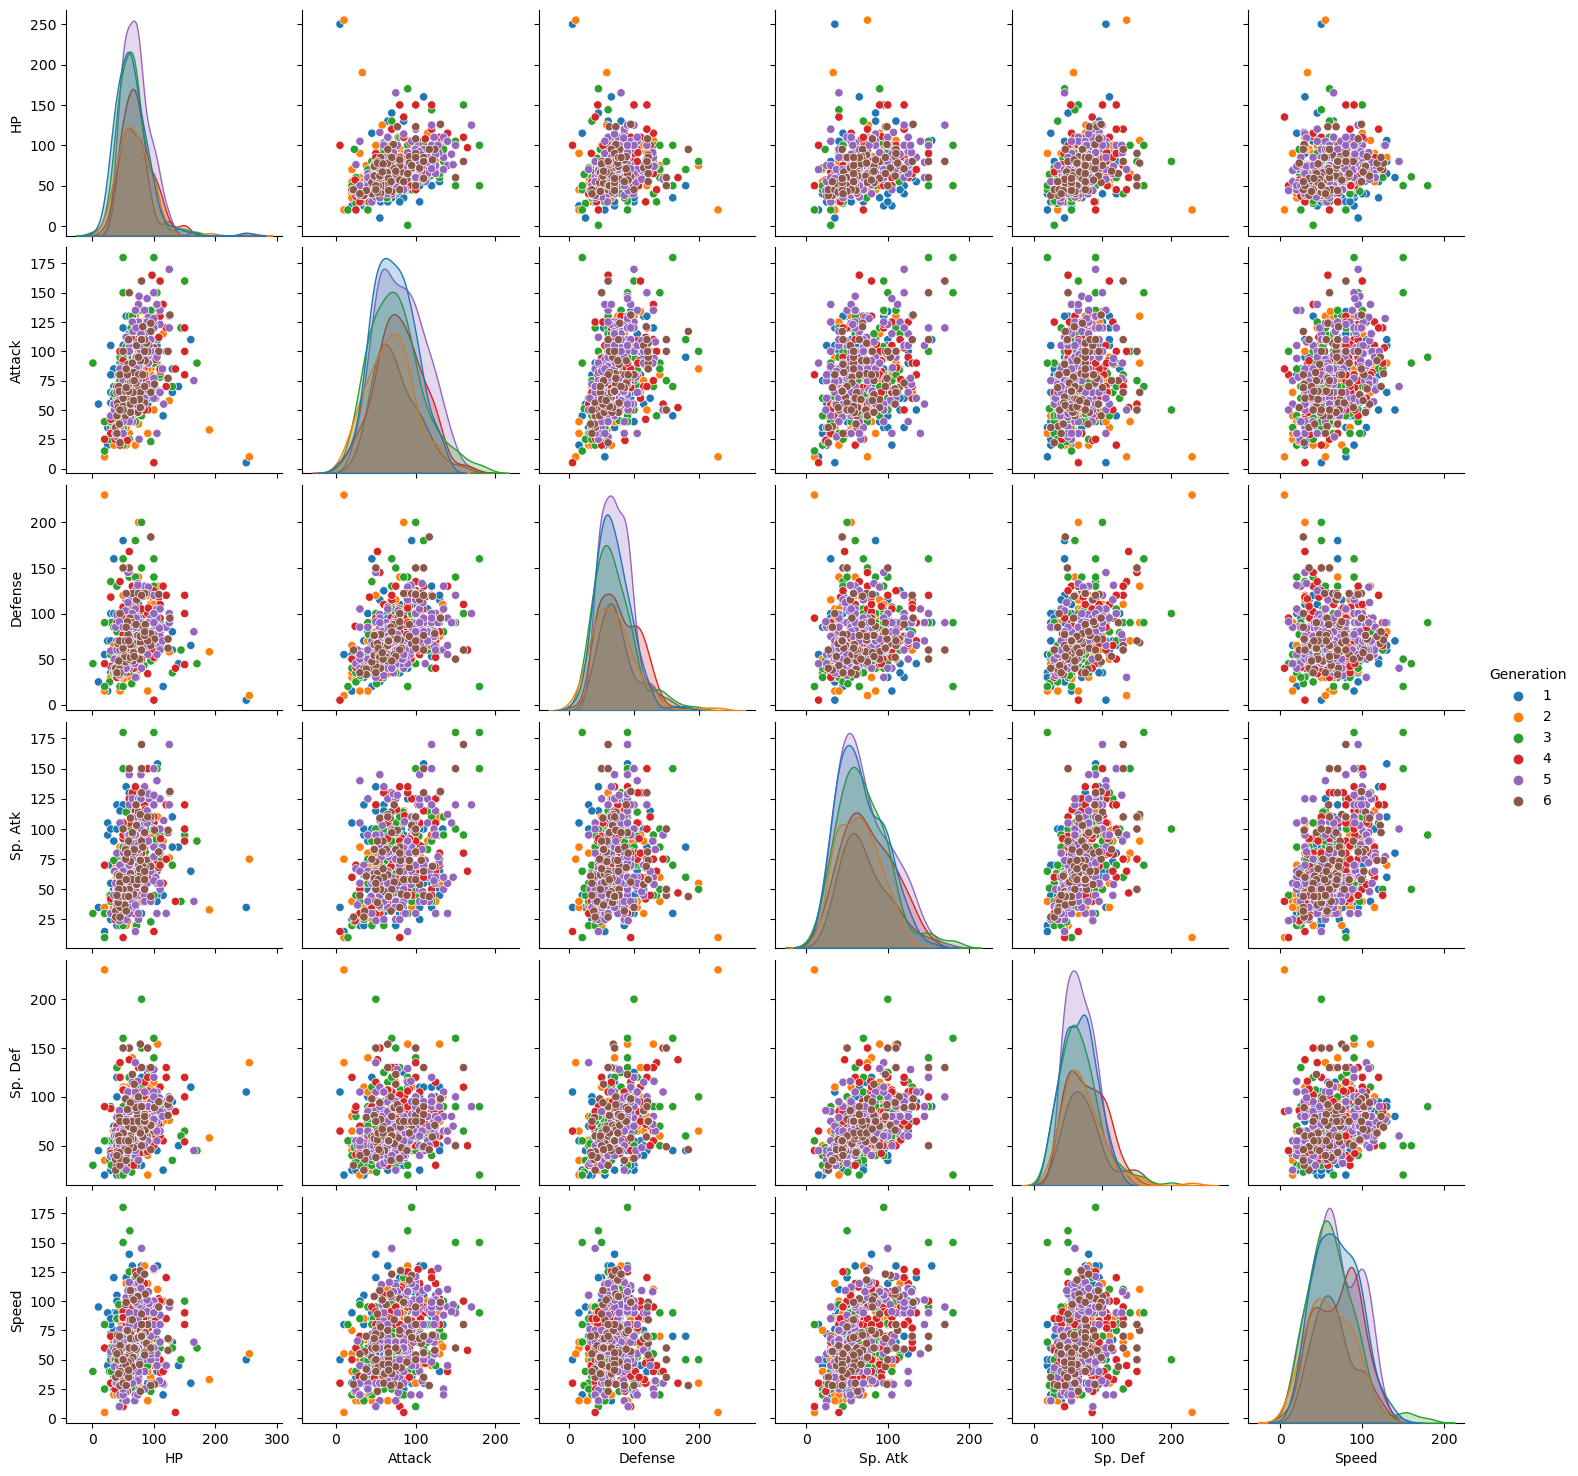

In [65]:
sns.pairplot(data=df.drop(columns=['Name', 'Type 1', 'Type 2', 'Legendary', 'ntype']), hue="Generation")
plt.show()

Although there seems to be a correlation between the variables, it is not strong enough to claim that they usually grow together. For instance, the two pokémons (from the first and second generation) with the largest HP are among the ones with the lowest attack and defense. Therefore, to determine the strongest pokémon, we have to create a single measure that can be used to compare them all. First, let us normalize their strengths variables.

In [66]:
scaler = MinMaxScaler()
columns = df.drop(columns=['Name', 'Type 1', 'Type 2', 'Legendary', 'ntype', 'Generation']).columns
df_norm = df.copy()
df_norm[columns] = scaler.fit_transform(df_norm[columns])
df_norm.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,ntype
0,Bulbasaur,Grass,Poison,0.173228,0.251429,0.195556,0.323529,0.214286,0.228571,1,False,Double
1,Ivysaur,Grass,Poison,0.232283,0.325714,0.257778,0.411765,0.285714,0.314286,1,False,Double
2,Venusaur,Grass,Poison,0.311024,0.440000,0.346667,0.529412,0.380952,0.428571,1,False,Double
3,Charmander,Fire,NaN,0.149606,0.268571,0.168889,0.294118,0.142857,0.342857,1,False,Single
4,Charmeleon,Fire,NaN,0.224409,0.337143,0.235556,0.411765,0.214286,0.428571,1,False,Single


In [67]:
(45-5)/(180-5)

0.22857142857142856

Now let us create an overall attribute which will be used to compare the pokémons. The overall will be the average of all the strengths attributes multiplied by a 100 to be better visualized.

In [68]:
df_norm['Overall'] = df_norm[columns].mean(axis=1)*100
df_norm.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,ntype,Overall
0,Bulbasaur,Grass,Poison,0.173228,0.251429,0.195556,0.323529,0.214286,0.228571,1,False,Double,23.109984
1,Ivysaur,Grass,Poison,0.232283,0.325714,0.257778,0.411765,0.285714,0.314286,1,False,Double,30.459004
2,Venusaur,Grass,Poison,0.311024,0.440000,0.346667,0.529412,0.380952,0.428571,1,False,Double,40.610431
3,Charmander,Fire,NaN,0.149606,0.268571,0.168889,0.294118,0.142857,0.342857,1,False,Single,22.781642
4,Charmeleon,Fire,NaN,0.224409,0.337143,0.235556,0.411765,0.214286,0.428571,1,False,Single,30.862162


Now let us see the top ten strongest pokémons.

In [69]:
df_norm.sort_values(['Overall'], ascending=False).reset_index(drop=True).head(10)

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,ntype,Overall
0,KyogrePrimal Kyogre,Water,NaN,0.389764,0.828571,0.377778,1.000000,0.666667,0.485714,3,True,Single,62.474899
1,GroudonPrimal Groudon,Ground,Fire,0.389764,1.000000,0.688889,0.823529,0.333333,0.485714,3,True,Double,62.020495
2,Arceus,Normal,NaN,0.468504,0.657143,0.511111,0.647059,0.476190,0.657143,4,True,Single,56.952501
3,KyuremWhite Kyurem,Dragon,Ice,0.488189,0.657143,0.377778,0.941176,0.380952,0.514286,5,True,Double,55.992070
4,KyuremBlack Kyurem,Dragon,Ice,0.488189,0.942857,0.422222,0.647059,0.333333,0.514286,5,True,Double,55.799104
5,HoopaHoopa Unbound,Psychic,Dark,0.311024,0.885714,0.244444,0.941176,0.523810,0.428571,6,True,Double,55.578996
6,Rayquaza,Dragon,Flying,0.409449,0.828571,0.377778,0.823529,0.333333,0.514286,3,True,Double,54.782441
7,Mewtwo,Psychic,NaN,0.413386,0.600000,0.377778,0.847059,0.333333,0.714286,1,True,Single,54.764025
8,Palkia,Water,Dragon,0.350394,0.657143,0.422222,0.823529,0.476190,0.542857,4,True,Double,54.538930
9,Reshiram,Dragon,Fire,0.389764,0.657143,0.422222,0.823529,0.476190,0.485714,5,True,Double,54.242717


Kyogre is the strongest pokémon, followed by Groudon. Both of them are from the third generation and have an overall above 62. Most of the pokémons in the top 10 have a double type with the type dragon being the most common. All of them a legendary and the second generation is the only one not to appear in the list. Now let us see the top 10 weakest pokémons. 

In [70]:
df_norm.sort_values(['Overall']).reset_index(drop=True).head(10)

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,ntype,Overall
0,Azurill,Normal,Fairy,0.192913,0.085714,0.155556,0.058824,0.095238,0.085714,3,False,Double,11.232652
1,Sunkern,Grass,NaN,0.114173,0.142857,0.111111,0.117647,0.047619,0.142857,2,False,Single,11.271079
2,Kricketot,Bug,NaN,0.141732,0.114286,0.160000,0.088235,0.100000,0.114286,4,False,Single,11.975650
3,Wurmple,Bug,NaN,0.173228,0.228571,0.133333,0.058824,0.047619,0.085714,3,False,Single,12.121500
4,Caterpie,Bug,NaN,0.173228,0.142857,0.133333,0.058824,0.000000,0.228571,1,False,Single,12.280230
5,Weedle,Bug,Poison,0.153543,0.171429,0.111111,0.058824,0.000000,0.257143,1,False,Double,12.534156
6,Silcoon,Bug,NaN,0.192913,0.171429,0.222222,0.088235,0.023810,0.057143,3,False,Single,12.595864
7,Cascoon,Bug,NaN,0.192913,0.171429,0.222222,0.088235,0.023810,0.057143,3,False,Single,12.595864
8,Metapod,Bug,NaN,0.192913,0.085714,0.222222,0.088235,0.023810,0.142857,1,False,Single,12.595864
9,Scatterbug,Bug,NaN,0.145669,0.171429,0.155556,0.100000,0.023810,0.171429,6,False,Single,12.798192


Azurill is the weakest pokémon, followed very closely by Sunkern. The great majority of them are from the type Bug and are single type. There are no legendary of fifth generation pokémons in the list.

## Generation Comparison

Now we can use the same overall attribute to compare the generations.

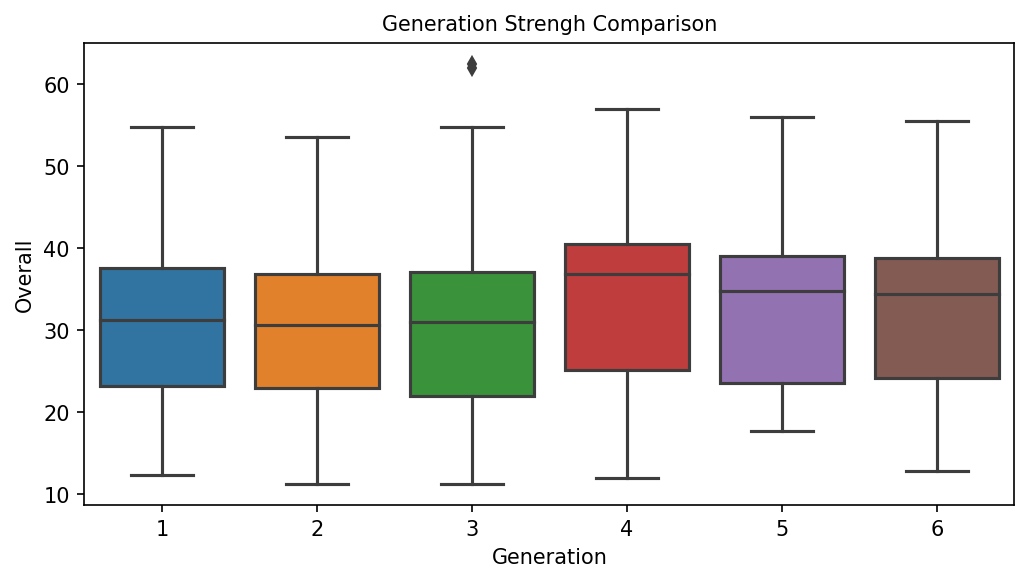

In [71]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
sns.boxplot(data=df_norm, x='Generation', y='Overall', ax=ax)
ax.set_title("Generation Strengh Comparison", fontdict={'fontsize':10})
plt.show()

The last 3 generations seem to be stronger than the first ones, with the fourth apparentely being the strongest. The two outliers we see in the third generation are Kyogre and Groundon, as we have seen above. In order to verify the claim that the fourth generation is indeed the strongest one, let us perform a t-test, comparing it with the second strongest one, the fifth.

In [72]:
stats.ttest_ind(df_norm.query("Generation==4")['Overall'], df_norm.query("Generation==5")['Overall'], equal_var=False, 
                alternative='greater')

Ttest_indResult(statistic=1.1986735502139927, pvalue=0.11592556998870365)

Since we do not have a pvalue below 0.05, we cannot reject the null hyphotesis of equal population means. Therefore, we don't have strong statistical evidence to claim that the fourth generation is indeed the strongest. Now let us check if we can sustain the claim that the latter generations are stronger than the first ones.

In [73]:
stats.ttest_ind(df_norm.query("Generation in (4, 5, 6)")['Overall'], df_norm.query("Generation in (1, 2, 3)")['Overall'],
               equal_var=False, alternative='greater')

Ttest_indResult(statistic=3.8379747963159834, pvalue=6.729620687941834e-05)

Since we have a  pvalue far below 0.05, we have statistical evidence strong enough to claim that the latter generations are indeed stronger than the first ones.

## Grouping Pokémons

Let us see if we can group pokémons according to their strengths. For doing so, we are going to be using the KMeans clustering method. First, we need to select the k value the best fits our data. In order to discover this value, we are going to be using the [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

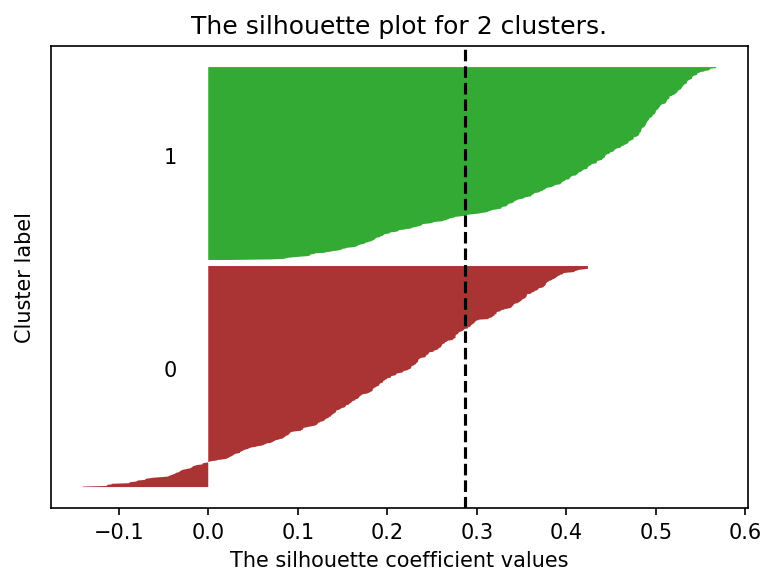

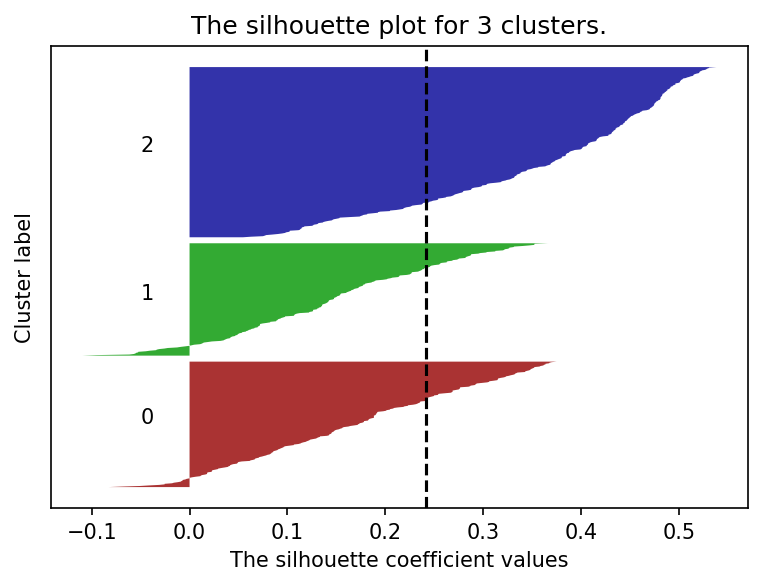

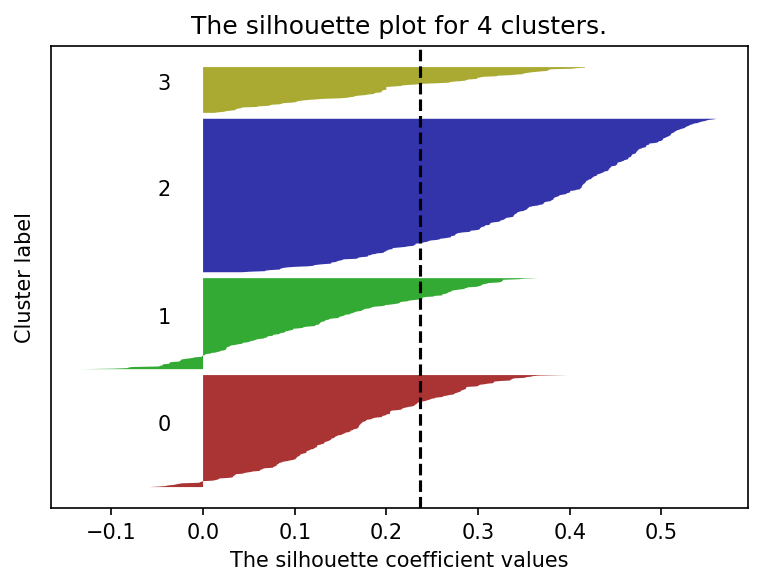

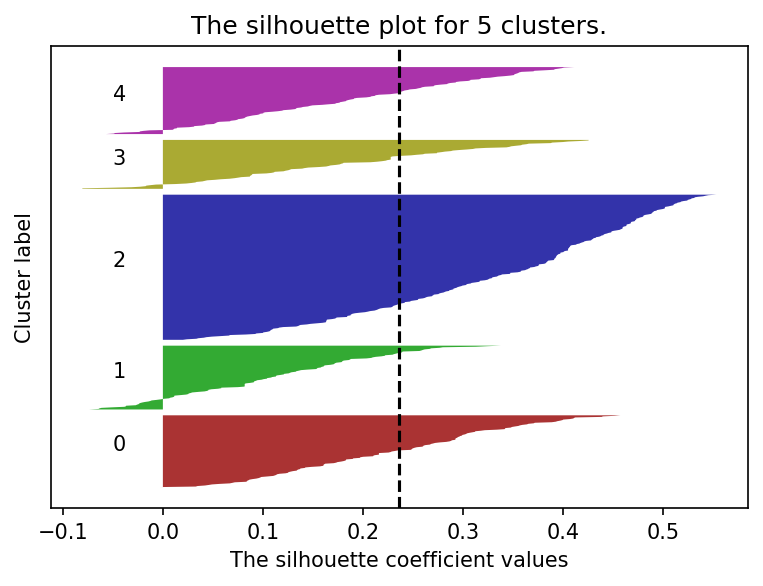

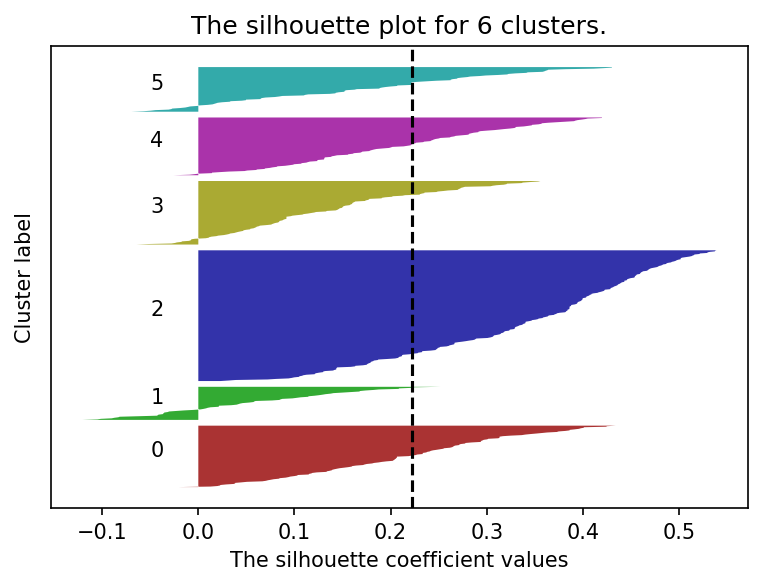

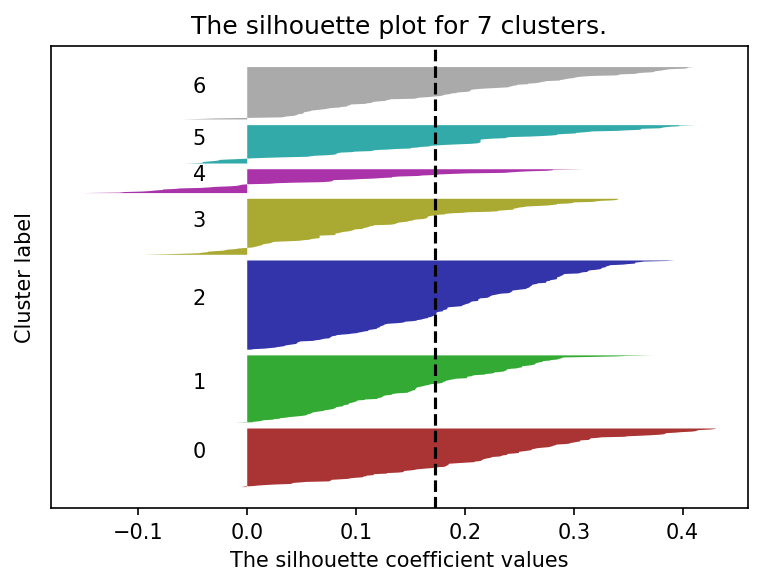

In [74]:
y_lower = 10
for k in range(2,8):
    fig, ax = plt.subplots(figsize=(6,4), dpi=150)
    clusterer = KMeans(n_clusters=k, n_init='auto', random_state=222)
    labels = clusterer.fit_predict(df_norm[columns])
    s_score = silhouette_score(df_norm[columns], labels)
    s_values = silhouette_samples(df_norm[columns], labels)
    for silhouette in range(k):
        cluster_silhouette_values = s_values[labels == silhouette]

        cluster_silhouette_values.sort()

        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        colors = ["#AA3333", "#33AA33", "#3333AA", "#AAAA33", "#AA33AA", "#33AAAA", "#AAAAAA"]
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_values,
            facecolor=colors[silhouette]
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(silhouette))

        y_lower = y_upper + 10

    ax.set_title("The silhouette plot for {} clusters.".format(k))
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=s_score, color="black", linestyle="--")
    ax.set_yticks([])
    
plt.show()

Since all of the plots show clusters with silhouettes scores above average, we will be choosing a k=2 clusters because it is the one where the plots have the most similar thickness. For sake of simplicity, we will not take into account the negative scores. Let us see how the normalized data is grouped.

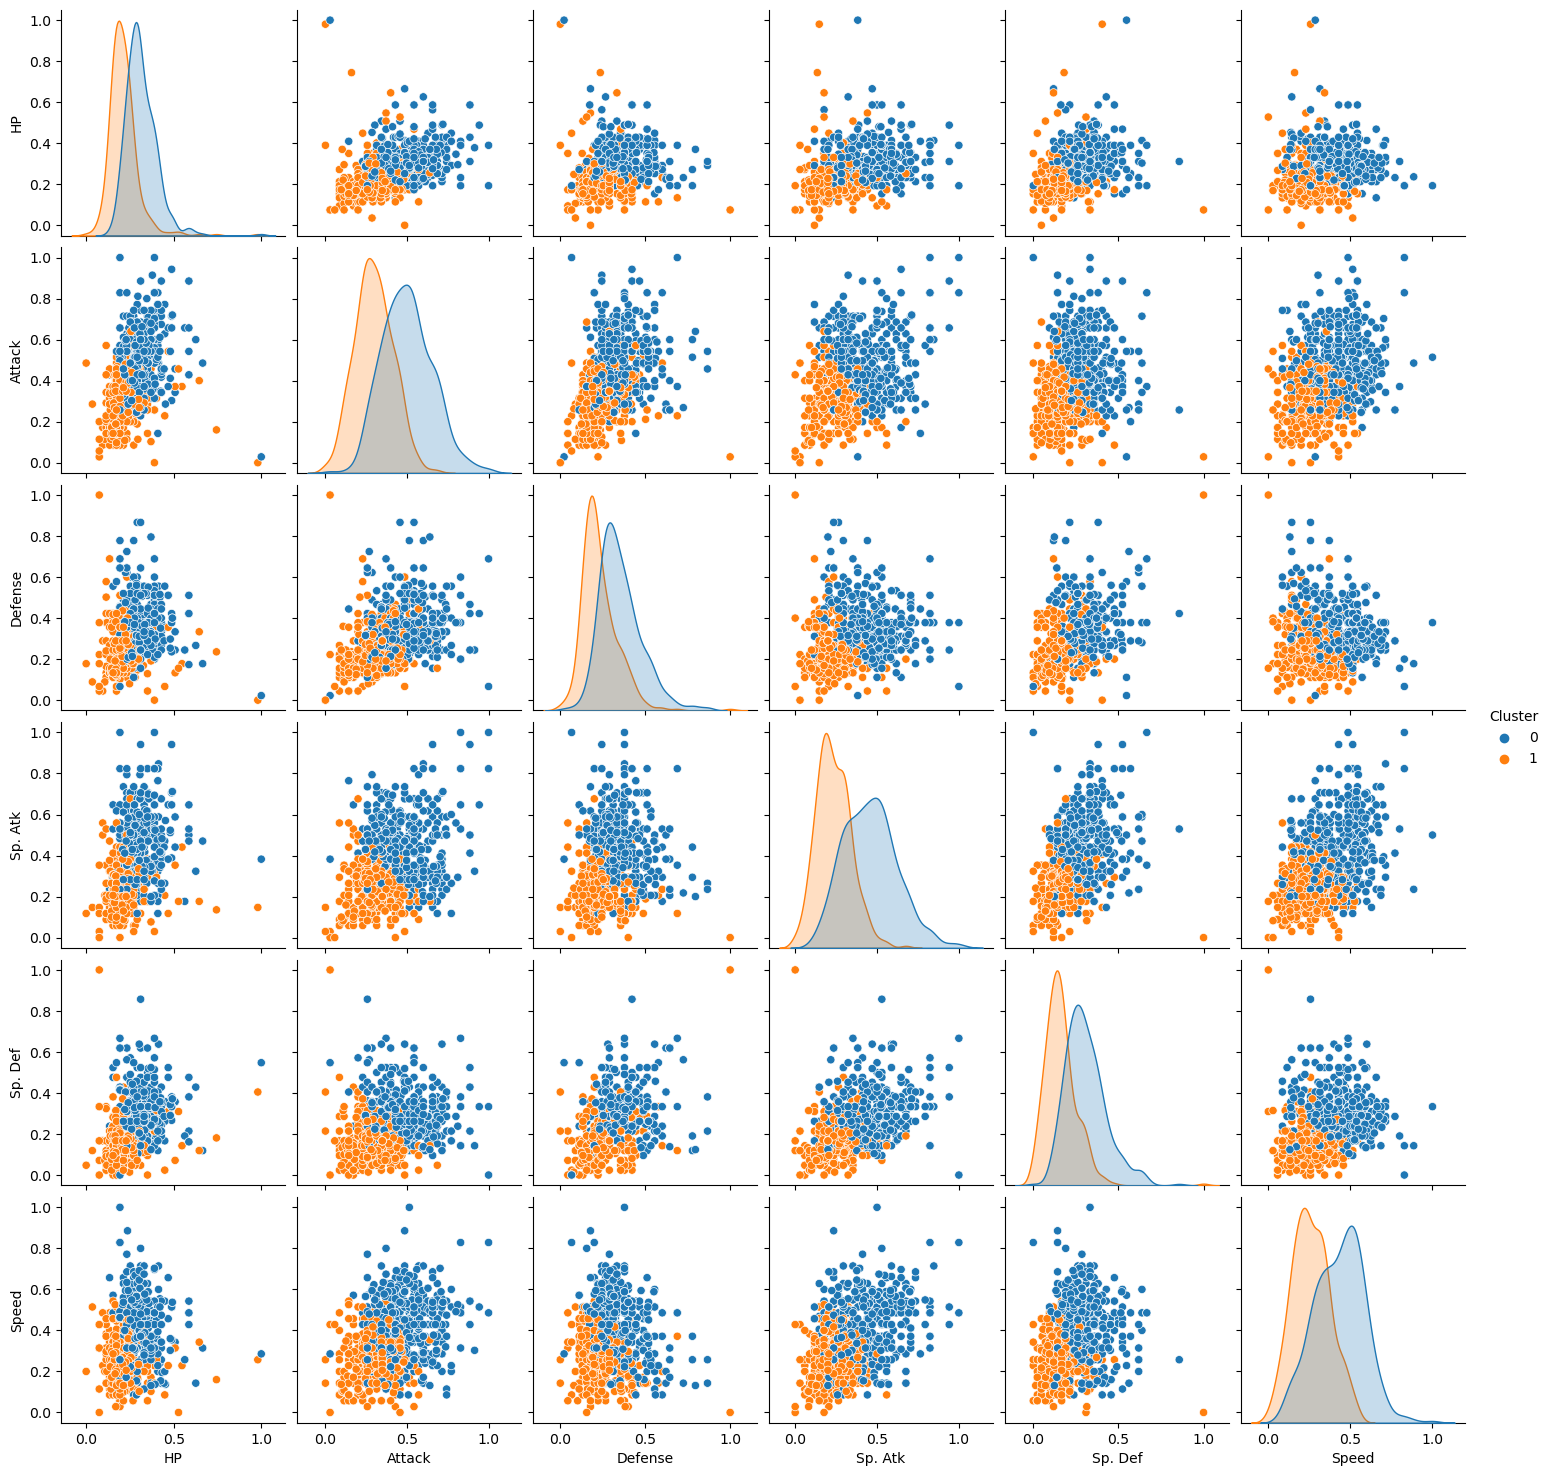

In [75]:
clusterer = KMeans(n_clusters=2, n_init='auto', random_state=222)
df_norm['Cluster'] = clusterer.fit_predict(df_norm[columns])
sns.pairplot(data=df_norm.drop(columns=['Name', 'Type 1', 'Type 2', 'Legendary', 'ntype', 'Generation', 'Overall']), 
             hue="Cluster")
plt.show()

The data seems to be more or less divided by strong (cluster 0) and weak (cluster 1) pokémons. Seeing the strenths distribution, all the means do seem to be different between the clusters. In order to verify so, let us use the overall attribute to perform a t-test.

In [76]:
stats.ttest_ind(df_norm.query("Cluster==0")['Overall'], df_norm.query("Cluster==1")['Overall'], equal_var=False, 
                alternative='greater')

Ttest_indResult(statistic=41.671248896327654, pvalue=1.442237686365287e-197)

The pvalue is almost 0, therefore, we have strong statistical evidence that the pokémons in the cluster 0 are, on average, stronger than the ones in the cluster 1. Let us rename the clusters.

In [77]:
df_norm['Cluster'] = np.where(df_norm['Cluster'], 'Weak', 'Strong')
df_norm.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,ntype,Overall,Cluster
0,Bulbasaur,Grass,Poison,0.173228,0.251429,0.195556,0.323529,0.214286,0.228571,1,False,Double,23.109984,Weak
1,Ivysaur,Grass,Poison,0.232283,0.325714,0.257778,0.411765,0.285714,0.314286,1,False,Double,30.459004,Weak
2,Venusaur,Grass,Poison,0.311024,0.440000,0.346667,0.529412,0.380952,0.428571,1,False,Double,40.610431,Strong
3,Charmander,Fire,NaN,0.149606,0.268571,0.168889,0.294118,0.142857,0.342857,1,False,Single,22.781642,Weak
4,Charmeleon,Fire,NaN,0.224409,0.337143,0.235556,0.411765,0.214286,0.428571,1,False,Single,30.862162,Strong


## Conclusion

In this project, we have analised all the pokémons from the 6 first generations. It was shown that almost half (49.93%) of the pokémons have 2 types and that the water type is the most common, whereas the fairy type is the rarest. Kyogre and Ground are respectively the first and second strongest pokémons, whereas Azurill is the weakest, very closely followed by Sunkern. All of the top 10 strongest pokémons are legendary. We have seen that the latter generations are stronger on average than the first ones and by the end, we divided pokémons between strong and weak, using the KMeans clustering technique.

